## roster model estimation

To determine the impact each roster position has on team success, we need to examine the quality of players per game and the result of each game. For each roster position, there will be elite players and secondary players per team. Elite players will be assinged a value of 1 whereas secondary players, a value 2.

### import data sets  "play by play goal detail" and "game detail"

In [204]:
import sys
import os
import pandas as pd
import numpy as np
import datetime, time
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pylab import hist, show
import scipy
import zipfile


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)


In [205]:
pwd

'/Users/stefanostselios/Desktop/nhl_roster_design-master'

In [206]:
d0 = pd.read_csv('season_games.csv', index_col=0)
d1 = pd.read_csv('season_game_team_roster.csv', index_col=0)

In [207]:
d0 = d0[['Season', 'GameNumber', 'VTeamCode', 'HTeamCode', 'HGF', 'VGF', 'GD', 'WinTeam']]
d0.head()

,Season,GameNumber,VTeamCode,HTeamCode,HGF,VGF,GD,WinTeam
0,2010,20001,MTL,TOR,3,2,1,TOR
1,2010,20002,PHI,PIT,2,3,-1,PHI
2,2010,20003,CAR,MIN,3,4,-1,CAR
3,2010,20004,CHI,COL,4,3,1,COL
4,2010,20005,CGY,EDM,4,0,4,EDM


In [208]:
dm = d0.merge(d1, on=['Season', 'GameNumber'], how='left')

- Calculate the difference between player quality per game for all positions with respect to home team ( Home Team - Visitor Team). There are 5 positions and 2 types of player quality. This will give us a total of 10 differenecs. 

In [209]:
dm = dm[dm['GameNumber'] <= 21230]
dm.shape

(2245, 14)

In [210]:
dm['GD'] = dm.apply(lambda x: (x['HGF'] - x['VGF']) if x['HTeamCode']== x['TeamCode'] else (x['VGF'] - x['HGF']), 1)

In [211]:
dm['Win'] = dm.apply(lambda x: 1 if x['WinTeam']== x['TeamCode'] else 0, 1)

In [212]:
dm['GF'] = dm.apply(lambda x: x['HGF'] if x['HTeamCode']== x['TeamCode'] else x['VGF'], 1)
dm['GA'] = dm.apply(lambda x: x['HGF'] if x['HTeamCode']!= x['TeamCode'] else x['VGF'], 1)

In [213]:
dm.head()

,Season,GameNumber,VTeamCode,HTeamCode,HGF,VGF,GD,WinTeam,TeamCode,RosterCount,D1,D2,F1,F2,Win,GF,GA
0,2010,20001,MTL,TOR,3,2,-1,TOR,MTL,18.0,1.0,5.0,2.0,10.0,0,2,3
1,2010,20001,MTL,TOR,3,2,1,TOR,TOR,18.0,1.0,5.0,2.0,10.0,1,3,2
2,2010,20002,PHI,PIT,2,3,1,PHI,PHI,18.0,2.0,4.0,5.0,7.0,1,3,2
3,2010,20002,PHI,PIT,2,3,-1,PHI,PIT,18.0,3.0,3.0,5.0,7.0,0,2,3
4,2010,20003,CAR,MIN,3,4,1,CAR,CAR,18.0,1.0,5.0,3.0,9.0,1,4,3


In [214]:
dm.shape

(2245, 17)

In [215]:
dm['F'] = dm['F1'] + dm['F2']
dm['D'] = dm['D1'] + dm['D2']

In [216]:
dm['DF'] = dm['F1'] - dm['F2']
dm['DD'] = dm['D1'] - dm['D2']

In [217]:
dm['F'].value_counts()

12.0    2030
Name: F, dtype: int64

In [218]:
dm['D'].value_counts()

6.0    2030
Name: D, dtype: int64

In [219]:
dm = dm.groupby(['Season', 'GameNumber']).filter(lambda x: ((x['F'] == 12) & (x['D'] == 6)).all())

In [220]:
dm.shape

(2030, 21)

In [221]:
dm['F'].value_counts()

12.0    2030
Name: F, dtype: int64

In [222]:
dm['D'].value_counts()

6.0    2030
Name: D, dtype: int64

## Summary analysis

In [223]:
dm.describe()

,Season,GameNumber,HGF,VGF,GD,RosterCount,D1,D2,F1,F2,Win,GF,GA,F,D,DF,DD
count,2030.0,2030.000000,2030.000000,2030.000000,2030.000000,2030.0,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2030.0,2030.0,2030.000000,2030.000000
mean,2010.0,20622.621675,2.941872,2.739901,0.000000,18.0,1.500493,4.499507,3.045813,8.954187,0.500000,2.840887,2.840887,12.0,6.0,-5.908374,-2.999015
std,0.0,352.093955,1.716062,1.633597,2.446268,0.0,0.984728,0.984728,1.574617,1.574617,0.500123,1.678379,1.678379,0.0,0.0,3.149234,1.969456
min,2010.0,20001.000000,0.000000,0.000000,-8.000000,18.0,0.000000,3.000000,0.000000,6.000000,0.000000,0.000000,0.000000,12.0,6.0,-12.000000,-6.000000
25%,2010.0,20319.250000,2.000000,2.000000,-2.000000,18.0,1.000000,4.000000,2.000000,8.000000,0.000000,2.000000,2.000000,12.0,6.0,-8.000000,-4.000000
50%,2010.0,20628.000000,3.000000,3.000000,0.000000,18.0,1.000000,5.000000,3.000000,9.000000,0.500000,3.000000,3.000000,12.0,6.0,-6.000000,-4.000000
75%,2010.0,20927.750000,4.000000,4.000000,2.000000,18.0,2.000000,5.000000,4.000000,10.000000,1.000000,4.000000,4.000000,12.0,6.0,-4.000000,-2.000000
max,2010.0,21230.000000,9.000000,10.000000,8.000000,18.0,3.000000,6.000000,6.000000,12.000000,1.000000,10.000000,10.000000,12.0,6.0,0.000000,0.000000


In [224]:
dm.groupby(['Win'])['F1', 'F2', 'D1', 'D2'].describe()

F1           F2           D1           D2
Win                                                          
0   count  1015.000000  1015.000000  1015.000000  1015.000000
    mean      2.760591     9.239409     1.367488     4.632512
    std       1.587930     1.587930     0.977018     0.977018
    min       0.000000     6.000000     0.000000     3.000000
    25%       2.000000     8.000000     1.000000     4.000000
    50%       3.000000     9.000000     1.000000     5.000000
    75%       4.000000    10.000000     2.000000     5.000000
    max       6.000000    12.000000     3.000000     6.000000
1   count  1015.000000  1015.000000  1015.000000  1015.000000
    mean      3.331034     8.668966     1.633498     4.366502
    std       1.508939     1.508939     0.974862     0.974862
    min       0.000000     6.000000     0.000000     3.000000
    25%       2.000000     7.000000     1.000000     4.000000
    50%       3.000000     9.000000     2.000000     4.000000
    75%       5.000000    10.000000     2.000000     5.000000
    max       6.000000    12.000000     3.000000     6.000000

## Mean number of F1, F2, D1 D1 per team

* create a season-team dataframe
  
  ** number of wins/points/winning percentage

### estimate roster model 

- regress home win on the difference in number of home and visitor players by position and quality (predictor variables). Add a constant to the predictors and use OLS. The purpose is to deterimine the impact each roster positin has on home team success.

In [225]:
y = dm['Win']  
X = sm.add_constant(dm[['F1', 'D1', 'F2', 'D2']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     34.41
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           2.02e-15
Time:                        16:42:37   Log-Likelihood:                -1439.5
No. Observations:                2030   AIC:                             2885.
Df Residuals:                    2027   BIC:                             2902.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0074      0.000     28.719      0.000         0.007     0.008
F1             0.0725      0.006     11.958      0.000         0.061     0.084
D1             0.0232      0.008      2.803      0.005         0.007     0.039
F2             0.0159      0.005      3.541      0.000         0.007     0.025
D2             0.0210      0.008      2.579      0.010         0.005     0.037
==============================================================================
Omnibus:                        0.004   Durbin-Watson:                   2.968
Prob(Omnibus):                  0.998   Jarque-Bera (JB):              295.236
Skew:                          -0.004   Prob(JB):                     7.77e-65
Kurtosis:                       1.132   Cond. No.                     1.54e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.84e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [226]:
result.params

const    0.007366
F1       0.072453
D1       0.023225
F2       0.015941
D2       0.020972
dtype: float64

In [227]:
y = dm['GD']  
X = sm.add_constant(dm[['F1', 'D1', 'F2', 'D2']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     36.57
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           2.51e-16
Time:                        16:42:37   Log-Likelihood:                -4659.9
No. Observations:                2030   AIC:                             9326.
Df Residuals:                    2027   BIC:                             9343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0095      0.001      7.557      0.000         0.007     0.012
F1             0.1810      0.030      6.115      0.000         0.123     0.239
D1             0.0711      0.040      1.757      0.079        -0.008     0.151
F2            -0.0674      0.022     -3.062      0.002        -0.111    -0.024
D2            -0.0143      0.040     -0.360      0.719        -0.092     0.064
==============================================================================
Omnibus:                        0.145   Durbin-Watson:                   3.033
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.191
Skew:                           0.014   Prob(JB):                        0.909
Kurtosis:                       2.961   Cond. No.                     1.54e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.84e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [228]:
y = dm['Win']  
X = sm.add_constant(dm[['F1', 'D1', 'F2', 'D2']] )
result = sm.Logit(y, X).fit()
result.summary()

         Current function value: 0.676525
         Iterations: 35


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:971: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 2030
Model:                          Logit   Df Residuals:                     2027
Method:                           MLE   Df Model:                            2
Date:                Mon, 27 Nov 2017   Pseudo R-squ.:                 0.02398
Time:                        16:42:37   Log-Likelihood:                -1373.3
converged:                      False   LL-Null:                       -1407.1
                                        LLR p-value:                 2.215e-15
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0077        nan        nan        nan           nan       nan
F1             0.1624        nan        nan        nan           nan       nan
D1             0.0264   2.85e+05   9.25e-08      1.000     -5.59e+05  5.59e+05
F2            -0.0705        nan        nan        nan           nan       nan
D2             0.0196   2.85e+05   6.88e-08      1.000     -5.59e+05  5.59e+05
==============================================================================
"""

In [229]:
dm.Win.mean()

0.5

In [230]:
y = dm['Win']  
X = sm.add_constant(dm[['DF', 'DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     34.41
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           2.02e-15
Time:                        16:42:38   Log-Likelihood:                -1439.5
No. Observations:                2030   AIC:                             2885.
Df Residuals:                    2027   BIC:                             2902.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6703      0.023     28.719      0.000         0.625     0.716
DF             0.0283      0.005      5.529      0.000         0.018     0.038
DD             0.0011      0.008      0.138      0.890        -0.015     0.017
==============================================================================
Omnibus:                        0.004   Durbin-Watson:                   2.968
Prob(Omnibus):                  0.998   Jarque-Bera (JB):              295.236
Skew:                          -0.004   Prob(JB):                     7.77e-65
Kurtosis:                       1.132   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [231]:
y = dm['Win']  
X = sm.add_constant(dm[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     68.83
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           1.93e-16
Time:                        16:42:38   Log-Likelihood:                -1439.5
No. Observations:                2030   AIC:                             2883.
Df Residuals:                    2028   BIC:                             2894.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6700      0.023     28.856      0.000         0.624     0.716
DF             0.0288      0.003      8.297      0.000         0.022     0.036
==============================================================================
Omnibus:                        0.005   Durbin-Watson:                   2.968
Prob(Omnibus):                  0.998   Jarque-Bera (JB):              295.254
Skew:                          -0.004   Prob(JB):                     7.70e-65
Kurtosis:                       1.132   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [232]:
y = dm['Win']  
X = sm.add_constant(dm[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Win   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     37.70
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           9.88e-10
Time:                        16:42:38   Log-Likelihood:                -1454.7
No. Observations:                2030   AIC:                             2913.
Df Residuals:                    2028   BIC:                             2925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6029      0.020     30.077      0.000         0.564     0.642
DD             0.0343      0.006      6.140      0.000         0.023     0.045
==============================================================================
Omnibus:                        0.000   Durbin-Watson:                   2.983
Prob(Omnibus):                  1.000   Jarque-Bera (JB):              313.929
Skew:                          -0.000   Prob(JB):                     6.78e-69
Kurtosis:                       1.073   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [233]:
y = dm['Win']  
X = sm.add_constant(dm[['DF', 'DD']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.676525
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 2030
Model:                          Logit   Df Residuals:                     2027
Method:                           MLE   Df Model:                            2
Date:                Mon, 27 Nov 2017   Pseudo R-squ.:                 0.02398
Time:                        16:42:38   Log-Likelihood:                -1373.3
converged:                       True   LL-Null:                       -1407.1
                                        LLR p-value:                 2.215e-15
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6973      0.098      7.138      0.000         0.506     0.889
DF             0.1165      0.021      5.426      0.000         0.074     0.159
DD             0.0034      0.034      0.100      0.920        -0.063     0.070
==============================================================================
"""

In [234]:
y = dm['Win']  
X = sm.add_constant(dm[['DF']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.676527
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 2030
Model:                          Logit   Df Residuals:                     2028
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 Nov 2017   Pseudo R-squ.:                 0.02398
Time:                        16:42:38   Log-Likelihood:                -1373.4
converged:                       True   LL-Null:                       -1407.1
                                        LLR p-value:                 2.132e-16
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6964      0.097      7.160      0.000         0.506     0.887
DF             0.1180      0.015      8.061      0.000         0.089     0.147
==============================================================================
"""

In [235]:
y = dm['Win']  
X = sm.add_constant(dm[['DD']] )
result = sm.Logit(y, X).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.683965
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Win   No. Observations:                 2030
Model:                          Logit   Df Residuals:                     2028
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 Nov 2017   Pseudo R-squ.:                 0.01325
Time:                        16:42:38   Log-Likelihood:                -1388.4
converged:                       True   LL-Null:                       -1407.1
                                        LLR p-value:                 1.024e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4167      0.082      5.070      0.000         0.256     0.578
DD             0.1389      0.023      6.050      0.000         0.094     0.184
==============================================================================
"""

In [236]:
y = dm['GD']
X = sm.add_constant(dm[['DF', 'DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     36.57
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           2.51e-16
Time:                        16:42:38   Log-Likelihood:                -4659.9
No. Observations:                2030   AIC:                             9326.
Df Residuals:                    2027   BIC:                             9343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8619      0.114      7.557      0.000         0.638     1.086
DF             0.1242      0.025      4.973      0.000         0.075     0.173
DD             0.0427      0.040      1.070      0.285        -0.036     0.121
==============================================================================
Omnibus:                        0.145   Durbin-Watson:                   3.033
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.191
Skew:                           0.014   Prob(JB):                        0.909
Kurtosis:                       2.961   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [237]:
y = dm['GD']  
X = sm.add_constant(dm[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     71.98
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           4.12e-17
Time:                        16:42:38   Log-Likelihood:                -4660.5
No. Observations:                2030   AIC:                             9325.
Df Residuals:                    2028   BIC:                             9336.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8497      0.113      7.488      0.000         0.627     1.072
DF             0.1438      0.017      8.484      0.000         0.111     0.177
==============================================================================
Omnibus:                        0.132   Durbin-Watson:                   3.034
Prob(Omnibus):                  0.936   Jarque-Bera (JB):                0.174
Skew:                           0.014   Prob(JB):                        0.917
Kurtosis:                       2.964   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
y = dm['GD']  
X = sm.add_constant(dm[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GD   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     47.84
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           6.17e-12
Time:                        16:42:38   Log-Likelihood:                -4672.2
No. Observations:                2030   AIC:                             9348.
Df Residuals:                    2028   BIC:                             9360.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5655      0.098      5.782      0.000         0.374     0.757
DD             0.1886      0.027      6.917      0.000         0.135     0.242
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   3.045
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.526
Skew:                           0.006   Prob(JB):                        0.769
Kurtosis:                       2.922   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [239]:
y = dm['GF']  
X = sm.add_constant(dm[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GF   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     26.57
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           2.79e-07
Time:                        16:42:38   Log-Likelihood:                -3917.9
No. Observations:                2030   AIC:                             7840.
Df Residuals:                    2028   BIC:                             7851.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.1990      0.079     40.639      0.000         3.045     3.353
DF             0.0606      0.012      5.155      0.000         0.038     0.084
==============================================================================
Omnibus:                       53.791   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.462
Skew:                           0.408   Prob(JB):                     3.33e-13
Kurtosis:                       3.109   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [240]:
y = dm['GF']  
X = sm.add_constant(dm[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     18.71
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           1.59e-05
Time:                        16:42:38   Log-Likelihood:                -3921.8
No. Observations:                2030   AIC:                             7848.
Df Residuals:                    2028   BIC:                             7859.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.0853      0.068     45.653      0.000         2.953     3.218
DD             0.0815      0.019      4.326      0.000         0.045     0.118
==============================================================================
Omnibus:                       52.016   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.484
Skew:                           0.403   Prob(JB):                     8.95e-13
Kurtosis:                       3.075   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [241]:
y = dm['GA']  
X = sm.add_constant(dm[['DF']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GA   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     50.67
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           1.51e-12
Time:                        16:42:38   Log-Likelihood:                -3906.1
No. Observations:                2030   AIC:                             7816.
Df Residuals:                    2028   BIC:                             7827.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.3493      0.078     30.019      0.000         2.196     2.503
DF            -0.0832      0.012     -7.118      0.000        -0.106    -0.060
==============================================================================
Omnibus:                       53.898   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.563
Skew:                           0.407   Prob(JB):                     3.16e-13
Kurtosis:                       3.128   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [242]:
y = dm['GA']  
X = sm.add_constant(dm[['DD']] )
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GA   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     32.53
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           1.35e-08
Time:                        16:42:38   Log-Likelihood:                -3915.0
No. Observations:                2030   AIC:                             7834.
Df Residuals:                    2028   BIC:                             7845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.5198      0.067     37.411      0.000         2.388     2.652
DD            -0.1071      0.019     -5.703      0.000        -0.144    -0.070
==============================================================================
Omnibus:                       52.140   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.546
Skew:                           0.400   Prob(JB):                     8.68e-13
Kurtosis:                       3.127   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

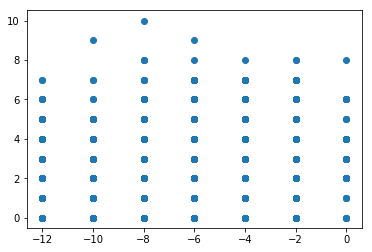

In [243]:
y = dm.GF
x = dm.DF
plt.scatter(x, y)
plt.show()